### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.metrics import silhouette_samples, silhouette_score
from pyclustertend import hopkins, ivat, vat
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as shc
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.ensemble import RandomForestClassifier
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
from shapely.geometry import Point
from geopandas import GeoDataFrame
import os
import warnings 
import random

### Adjusting settings

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
random.seed(10)

### Defining reusable functions

### Scaling data

In [3]:
def scale_data(df, scale_function):
    
    df_scaled = pd.DataFrame(scale_function.fit_transform(df))
    df_scaled.columns = data_f.columns
    return df_scaled

### Detecting outliers in data

In [4]:
def detect_outliers(df, col):
    
    perc_25 = np.percentile(df[col], 25)
    perc_75 = np.percentile(df[col], 75)
    iqr = perc_75 - perc_25
    ll = perc_25 - 1.5*iqr
    ul = perc_75 + 1.5*iqr
    
    print("Feature :", col)
    print("\n IQR {} \n Lower limit {}\n Upper limit {}".format(iqr, ll, ul))
    print("\n Minimum {} \n Maximum {} \n".format(min(df[col]), max(df[col])))
    
    if min(df[col]) < ll and max(df[col]) > ul:
        print("There are samples which violate both upper limit and lower limit")
        idx = np.where((df[col] < ll) and (df[col] > ul))
        print("Number of samples violating both upper limit and lower limitt :", len(idx[0]))

    elif min(df[col]) < ll and max(df[col]) <= ul:
        print("There are samples which violate only lower limit")
        idx = np.where(df[col] < ll)
        print("Number of samples violating lower limit :", len(idx[0]))
        
    elif min(df[col]) >= ll and max(df[col]) > ul:
        print("There are samples which violate only upper limit")
        idx = np.where(df[col] > ul)
        print("Number of samples violating upper limit :", len(idx[0]))
    
    print("-------------------------------------------------------------------------------")

### Visualisation

In [5]:
def density_plots(df):
    
    cols = df.columns

    for i in range(len(cols)):
        plt.figure()
        sns.histplot(data=df, x=cols[i], kde = True)
        plt.title("Distribution for feature "+ str(cols[i]))
        plt.show()

In [6]:
def scatterplot_cluster_level(df):
    
    cols = df.columns
    
    for i in range(1, (len(cols)-1)):
        
        ser = df[cols[i]]
        plt.figure()
        sns.scatterplot(data=kmeans_3, x=ser.index, y= ser, hue="cluster_num", palette="deep")
        plt.title(str(cols[i]) + " for different clusters")
        plt.show()

### Elbow method to determine number of clusters

In [7]:
def wcss(df):
    
    wcss = []
    for i in range(1, 15):
        model_kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        model_kmeans.fit(df)
        wcss.append(model_kmeans.inertia_)  
    
    plt.figure(figsize=(10,5))
    plt.plot(range(1, 15), wcss)
    plt.title('The Elbow Point Graph')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

### Silhouette score

In [8]:
def silhouette_visualise(df):
    
    fig, ax = plt.subplots(3, 2, figsize=(15,8))
    
    for i in [2, 3, 4, 5, 6, 7]:
        
        model = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
        q, mod = divmod(i, 2)

        visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(df)

### Modelling

In [9]:
def clustering_model(df, model):
    
    cluster_model = model.fit(df)
    cluster_labels = cluster_model.labels_
    silhouette_score_dataset = silhouette_score(df, cluster_labels)
    
    df_f = pd.concat([data, pd.DataFrame(cluster_labels)], axis = 1)
    df_f.rename({0: 'cluster_num'}, axis=1, inplace = True) 

    print("Model used :", model)
    print("Silhouette score :", silhouette_score_dataset)
    
    return df_f

### Feature importance

In [10]:
def feature_importance_clustering(df):
    
    clusters = list(np.sort(df["cluster_num"].unique()))
    
    for i in range(len(clusters)):
        curr_cluster = clusters[i]
        temp_df = df.copy()
        temp_df["cluster_num"] = temp_df["cluster_num"].apply(lambda x: -1 if x != curr_cluster else x)
        
        features = temp_df.iloc[:,1:-1]
        target = temp_df.iloc[:,-1]
        
        clf = RandomForestClassifier(n_estimators = 10, max_depth=5, random_state=0)
        clf.fit(features, target)
        
        imp = pd.DataFrame(clf.feature_importances_)
        f = pd.DataFrame(features.columns)
        
        imp_df = pd.concat([f, imp], axis = 1)
        imp_df.columns = ['features','importance']
        imp_df = imp_df.sort_values(by = 'importance', ascending=False)
        
        plt.figure()
        imp_df.plot.bar(x = 'features', y = 'importance')
        plt.title("Feature importance for cluster :"+ str(curr_cluster))
        plt.xlabel("Feature")
        plt.ylabel("Feature importance")
        plt.show()

#### Note: https://www.xspdf.com/resolution/58672381.html

### Visualising on map

In [11]:
geopy.geocoders.options.default_user_agent = "mitra.nitian@gmail.com"
geolocator = Nominatim()

def geolocate(df):
    
    df["Location"] = df["country"].apply(lambda x: geolocator.geocode(x))
    df.dropna(inplace = True)
    df["Latitude"] = df["Location"].apply(lambda x: x.latitude)
    df["Longitude"] = df["Location"].apply(lambda x: x.longitude)
    df["col"] = df["cluster_num"].apply(lambda x: 'red' if x == 0 else ('yellow' if x == 1 else 'black')) 
    
    #world_map= folium.Map(tiles="cartodbpositron")
    #marker_cluster = MarkerCluster().add_to(world_map)
    df_loc = df[["Latitude", "Longitude"]]
    geometry = [Point(xy) for xy in zip(df_loc['Longitude'], df_loc['Latitude'])]
    gdf = GeoDataFrame(df_loc, geometry=geometry)  
    gdf["col"] = df["col"]
    gdf["cluster_num"] = df["cluster_num"]
    gdf.reset_index(inplace = True)
    
    leg_labels = "[red - cluster 0, yellow - cluster 1, black - cluster 2]"
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(ax=world.plot(figsize=(15, 10)), marker='o', color= gdf["col"], markersize=30)
    
    print("\n" + "\033[1m" + "Legend - " + leg_labels)

### Define path and load data

In [12]:
path = "/Users/sohinimitra/Documents/Kaggle/datasets/kaggle-country-clustering-datasets/"

data = pd.read_csv(path + "Country-data.csv")
data.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [13]:
data_dict = pd.read_csv(path + "data-dictionary.csv")
data_dict

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 1000 live births
2,exports,Exports of goods and services per capita. Given as %age of the GDP per capita
3,health,Total health spending per capita. Given as %age of GDP per capita
4,imports,Imports of goods and services per capita. Given as %age of the GDP per capita
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of the Total GDP
7,life_expec,The average number of years a new born child would live if the current mortality patterns are to remain the same
8,total_fer,The number of children that would be born to each woman if the current age-fertility rates remain the same.
9,gdpp,The GDP per capita. Calculated as the Total GDP divided by the total population.


### Check number of records, presence of NULLs and duplicates in the dataset

In [14]:
print("Number of records :", data.shape)
print("\n")
data.info()

Number of records : (167, 10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


#### Observations: <br>1. There are 167 records in the dataset. <br>2. Each record has 10 attributes. <br>3. There are no NULLs.

In [15]:
data.drop_duplicates(inplace = True)
print("Number of records after dropping duplicates :", data.shape)

Number of records after dropping duplicates : (167, 10)


#### Observation: There are no duplicates in the dataset

### Converting % features to absolute values

In [16]:
for i in ['imports','exports','health']:
    data[i] = (data[i] * data['gdpp'])/100
data.sample(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
151,Tonga,17.4,440.200,179.985,2140.650,4980,3.680,69.9,3.91,3550
64,Guinea-Bissau,114.0,81.503,46.495,192.544,1390,2.970,55.6,5.05,547
1,Albania,16.6,1145.200,267.895,1987.740,9930,4.490,76.3,1.65,4090
126,Rwanda,63.6,67.560,59.115,168.900,1350,2.610,64.6,4.51,563
53,Finland,3.0,17879.400,4134.900,17278.800,39800,0.351,80.0,1.87,46200


### Overview of numerical attributes

In [17]:
data_f = data.iloc[:,1:]
#data_f.head(5)
data_f.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Outlier detection

In [18]:
detect_outliers(data_f, "child_mort")
detect_outliers(data_f, "exports")
detect_outliers(data_f, "health")
detect_outliers(data_f, "imports")
detect_outliers(data_f, "income")
detect_outliers(data_f, "inflation")
detect_outliers(data_f, "life_expec")
detect_outliers(data_f, "total_fer")
detect_outliers(data_f, "gdpp")

Feature : child_mort

 IQR 53.85 
 Lower limit -72.525
 Upper limit 142.875

 Minimum 2.6 
 Maximum 208.0 

There are samples which violate only upper limit
Number of samples violating upper limit : 4
-------------------------------------------------------------------------------
Feature : exports

 IQR 6830.86 
 Lower limit -9799.15
 Upper limit 17524.29

 Minimum 1.0769199999999999 
 Maximum 183750.0 

There are samples which violate only upper limit
Number of samples violating upper limit : 18
-------------------------------------------------------------------------------
Feature : health

 IQR 898.4045000000001 
 Lower limit -1269.0712500000002
 Upper limit 2324.5467500000004

 Minimum 12.821200000000001 
 Maximum 8663.599999999999 

There are samples which violate only upper limit
Number of samples violating upper limit : 24
-------------------------------------------------------------------------------
Feature : imports

 IQR 7079.385 
 Lower limit -9978.8625
 Upper limit 18338.6

#### Observation: <br> 1. There is noise in data <br> 2. Outliers have not been removed as they may form a separate cluster

### EDA

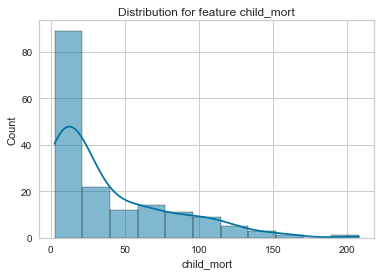

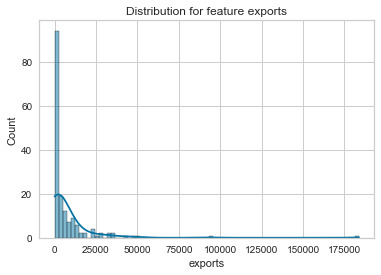

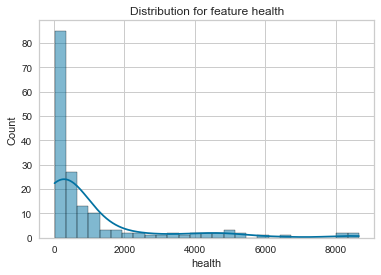

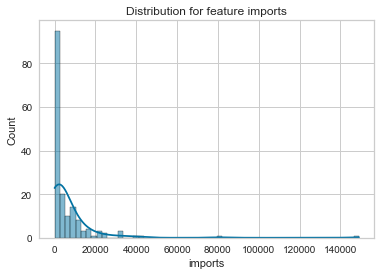

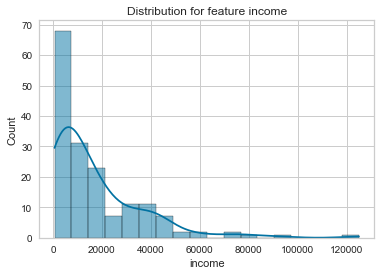

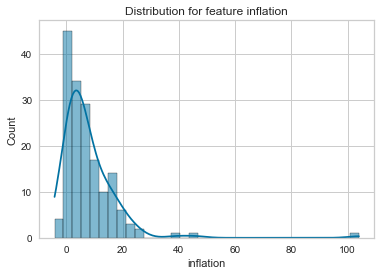

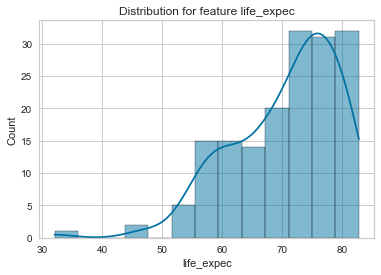

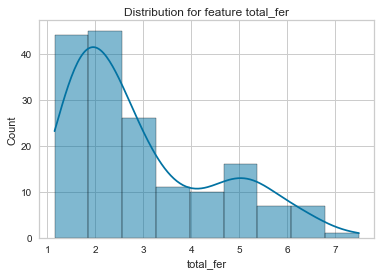

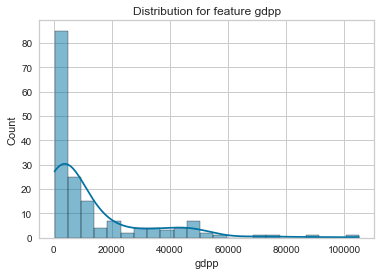

In [19]:
density_plots(data_f)

#### Observation: Different density zones can be observed across all features

In [20]:
#sns.pairplot(data_f, kind="kde", corner = True)

#### Observation: Pairwise density plots. Different density zones can be observed at a pair-wise level too.

### Scaling data

In [21]:
data_f_scaled = scale_data(data_f, MinMaxScaler())
data_f_scaled.sample(5)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
19,0.214216,0.004434,0.009596,0.004551,0.038596,0.120044,0.779093,0.323344,0.016694
127,0.079357,0.005477,0.024321,0.012282,0.038516,0.054801,0.777120,0.503155,0.030725
44,0.007303,0.159396,0.762842,0.169601,0.348827,0.068663,0.934911,0.113565,0.551394
49,0.527751,0.079841,0.087074,0.067547,0.266024,0.269014,0.568047,0.640379,0.161011
117,0.083252,0.030775,0.074174,0.042374,0.118907,0.062841,0.901381,0.231861,0.074917


### Determining clustering tendency

In [22]:
hopkins(data_f_scaled, 70)

0.07559012386729407

#### Note: <br>1.https://pyclustertend.readthedocs.io/en/latest/ <br>2. https://www.datanovia.com/en/blog/clustering-example-4-steps-you-should-know/ <br>3. A lower hopkins value (lies between 0 to 1) represents high clustering tendency.

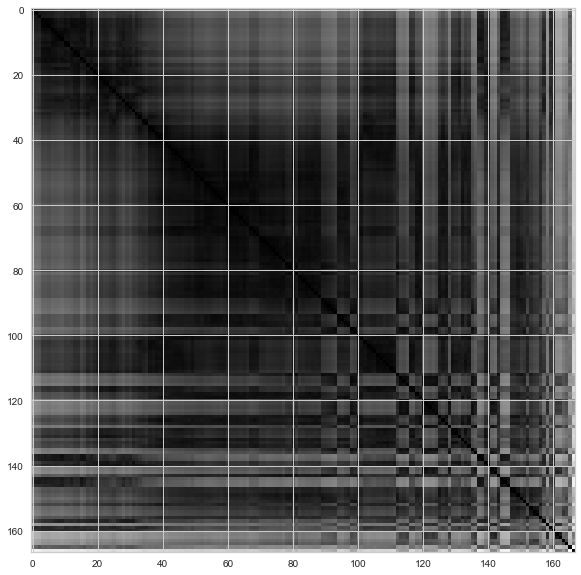

In [23]:
#vat(pd.DataFrame(scale(data_f)))
vat(pd.DataFrame(data_f_scaled))

#### The more the color is black, the more the distance between two observations is small. Here, the clusters may not be widely separated since the black colors are light. A way to interpert the image is to count the number of black square in the diagonal which should represent the number of cluster. Here ~3 or ~4 clusters.

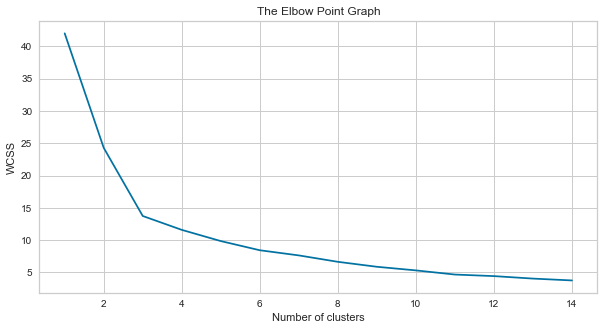

In [24]:
wcss(data_f_scaled)

#### Obsrvation: Within cluster squared error also confirms ~3 or ~4 clusters. 

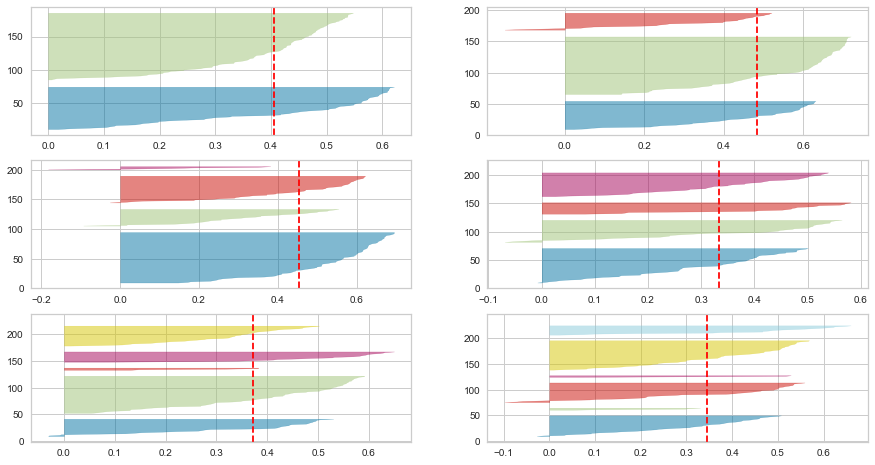

In [25]:
silhouette_visualise(data_f_scaled)

#### Observation: ~3 or ~4 clusters <br> https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam

### Clustering

### K-means

In [26]:
model = KMeans(n_clusters=3, random_state=10)
kmeans_3 = clustering_model(data_f_scaled, model)

Model used : KMeans(n_clusters=3, random_state=10)
Silhouette score : 0.483950905868675


In [27]:
model = KMeans(n_clusters=4, random_state=10)
kmeans_4 = clustering_model(data_f_scaled, model)

Model used : KMeans(n_clusters=4, random_state=10)
Silhouette score : 0.48278018477973417


#### Observation: 3 clusters have slightly higher silhouette score than 4 clusters. Hence, final number of clusters is chosen to be 3.

In [28]:
kmeans_3.sample(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_num
39,Costa Rica,10.2,2722.400,893.8000,2870.00,13000,6.57,80.4,1.92,8200,0
100,Mauritius,15.0,4096.000,480.0000,4976.00,15900,1.13,73.4,1.57,8000,0
92,"Macedonia, FYR",10.4,1806.920,321.8860,2637.74,11400,2.04,74.0,1.47,4540,0
27,Cambodia,44.4,425.226,44.6448,467.67,2520,3.12,66.1,2.88,786,0
102,Moldova,17.2,638.960,190.7100,1279.55,3910,11.10,69.7,1.27,1630,0


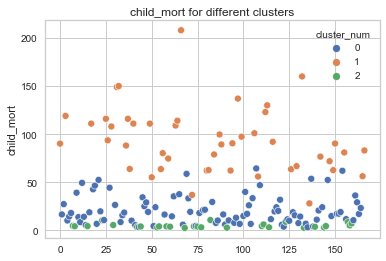

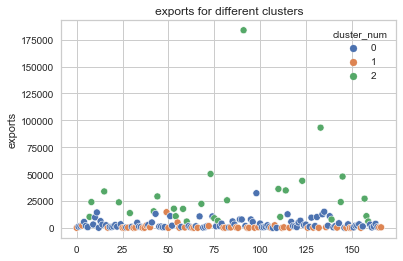

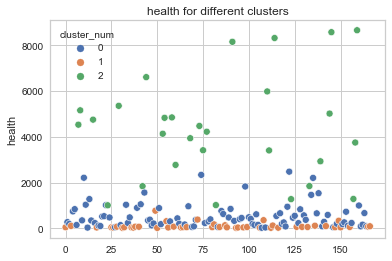

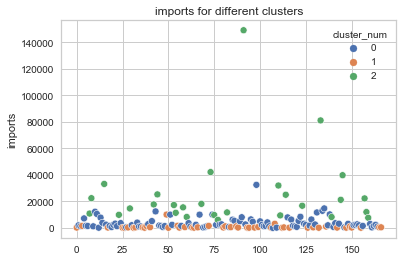

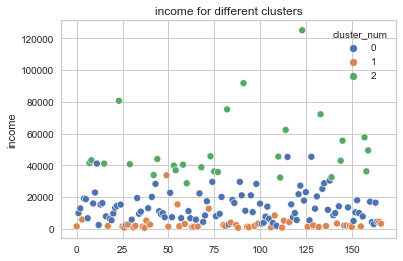

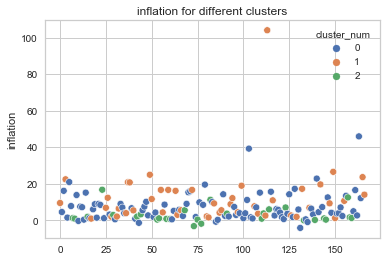

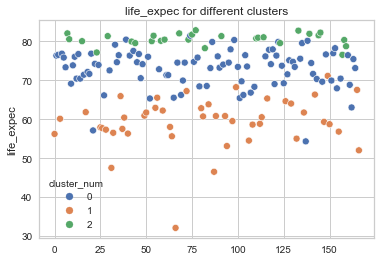

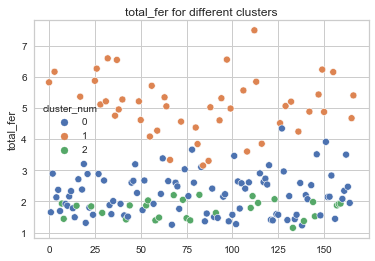

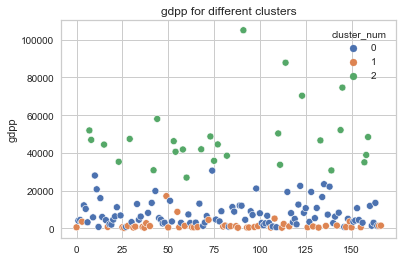

In [29]:
scatterplot_cluster_level(kmeans_3)

<Figure size 432x288 with 0 Axes>

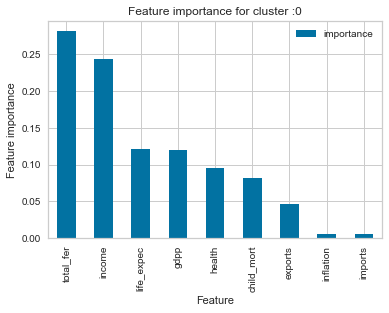

<Figure size 432x288 with 0 Axes>

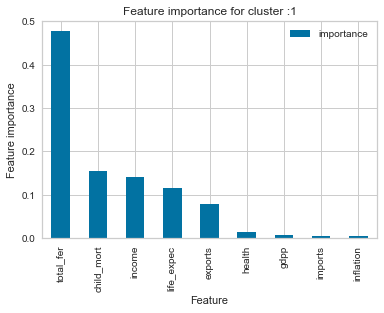

<Figure size 432x288 with 0 Axes>

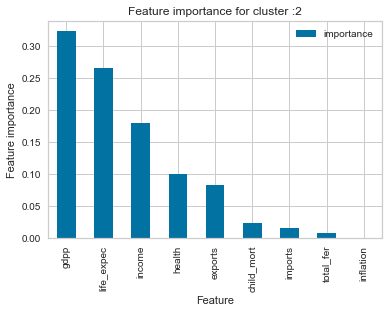

In [30]:
feature_importance_clustering(kmeans_3)

In [31]:
kmeans_3["cluster_num"].value_counts()

0    93
1    46
2    28
Name: cluster_num, dtype: int64


Legend - [red - cluster 0, yellow - cluster 1, black - cluster 2]


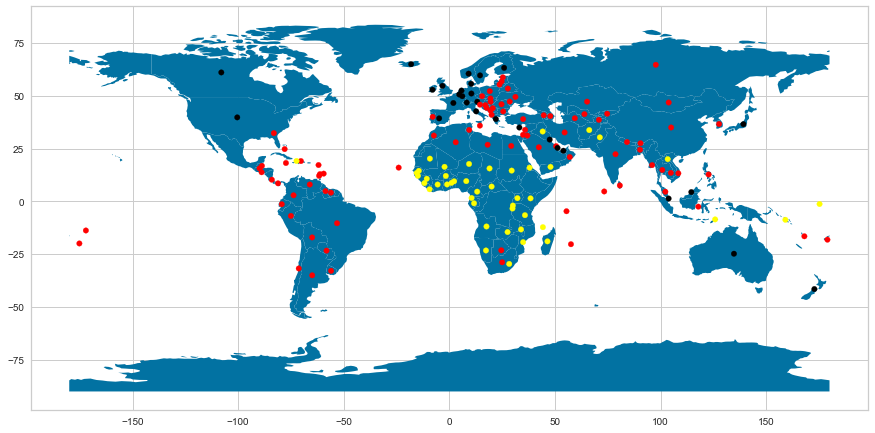

In [32]:
geolocate(kmeans_3)

### Observations: <br>From feature importance and cluster-wise feature visualisation, the following can be concluded: <br> 1. 93 countries belong to clusrer 0 (red). <br> 2. Primary features in Cluster 0 are total_fer and income. <br> 3. Both total_fer and income are of a moderate level in these countries. A similar trend is obseved for the other features as well. <br> 4. 46 countries belong to cluster 1 (yellow). <br> 5. Primary features in Cluster 1 are total_fer and child_mort. <br>6. Both total_fer and child_mort are high in these countries. Other features are mostly lowest in these countries (income, gdpp etc.). <br>7. 28 countries belong to cluster 2 (black). <br>8. Primary features in Cluster 2 are gdpp, life_expec, income. <br>9. All of gdpp, life_expec and income values are high in these countries. A similar trend is observed across most of the other features as well. 